In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from ctgan import CTGAN
from ctgan import load_demo
import data_describe as dd
import warnings
warnings.filterwarnings("ignore")

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, StratifiedKFold, GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import StandardScaler

from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import PolynomialFeatures

In [2]:
data = pd.read_csv('../data/S&P 500 Industrials 50-Day.csv')
data.rename(columns={'Unnamed: 0':'date'}, inplace=True)
data = data.sort_values(by=['date'])
data = data.dropna()
data

,date,S&P 500,S&P 500 Industrials (Sector),S&P 500 Performance (%),S&P 500 Industrials (Sector) Performance (%),S&P 500 Industrials (Sector) Outperform/Underperform,overall,energy,commodities,communication,transportation,services,durable
1159,1997-12-02,971.68,210.110001,-4.745660,-4.155643,OUTPERFORM,162.000,107.500,142.000,99.60,143.000,182.1,127.800
1160,1997-12-03,976.77,209.130005,-4.496656,-5.126339,UNDERPERFORM,162.000,107.500,142.000,99.60,143.000,182.1,127.800
1161,1997-12-04,973.10,208.500000,-5.714673,-5.647568,OUTPERFORM,162.000,107.500,142.000,99.60,143.000,182.1,127.800
1162,1997-12-05,983.79,210.610001,-4.326643,-4.050113,OUTPERFORM,162.000,107.500,142.000,99.60,143.000,182.1,127.800
1163,1997-12-08,982.37,210.490005,-5.012522,-4.518028,OUTPERFORM,162.000,107.500,142.000,99.60,143.000,182.1,127.800
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7194,2021-11-24,4701.46,895.200012,4.852728,5.676952,OUTPERFORM,280.126,263.553,210.452,76.33,250.105,348.1,126.416
7195,2021-11-26,4594.62,870.760010,1.616263,1.769479,OUTPERFORM,280.126,263.553,210.452,76.33,250.105,348.1,126.416
7196,2021-11-29,4655.27,872.809998,1.484354,0.632983,UNDERPERFORM,280.126,263.553,210.452,76.33,250.105,348.1,126.416
7197,2021-11-30,4567.00,850.539978,1.396956,-0.284886,UNDERPERFORM,280.126,263.553,210.452,76.33,250.105,348.1,126.416


## Using data after 2010

In [3]:
data['date'] = pd.to_datetime(data['date'])
data['month'] = data['date'].dt.month
data['year'] = data['date'].dt.year
data['dow'] = data['date'].dt.dayofweek
data = data[data['dow']==3].groupby(['year','month']).nth[1].reset_index()
data = data[data['year'] >= 2010]
data

,year,month,date,S&P 500,S&P 500 Industrials (Sector),S&P 500 Performance (%),S&P 500 Industrials (Sector) Performance (%),S&P 500 Industrials (Sector) Outperform/Underperform,overall,energy,commodities,communication,transportation,services,durable,dow
145,2010,1,2010-01-14,1148.46,257.549988,-2.110431,-6.113305,UNDERPERFORM,217.281,209.624,174.321,84.849,191.978,259.970,111.811,3
146,2010,2,2010-02-11,1078.47,242.679993,-11.020997,-16.294156,UNDERPERFORM,217.353,209.326,174.137,84.868,191.375,260.342,111.683,3
147,2010,3,2010-03-11,1150.24,262.059998,5.750719,2.455235,UNDERPERFORM,217.403,209.219,173.874,84.840,191.249,260.672,111.397,3
148,2010,4,2010-04-08,1186.44,276.230011,6.168177,6.009903,UNDERPERFORM,217.290,206.631,173.367,84.738,190.231,260.932,111.206,3
149,2010,5,2010-05-13,1157.44,277.670013,3.805347,4.599571,OUTPERFORM,217.199,203.764,172.929,84.622,189.426,261.188,110.989,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,2021,7,2021-07-08,4320.82,861.239990,-2.530346,1.777355,OUTPERFORM,273.092,242.958,201.975,76.056,236.783,342.831,120.078,3
284,2021,8,2021-08-12,4460.83,889.830017,-1.849766,0.460629,OUTPERFORM,274.214,245.847,203.215,76.337,237.107,343.808,120.714,3
285,2021,9,2021-09-09,4493.28,863.659973,-4.490556,-3.717911,OUTPERFORM,276.590,255.010,206.035,76.407,241.826,345.648,122.650,3
286,2021,10,2021-10-14,4438.26,861.609985,-7.366228,-3.029728,OUTPERFORM,278.524,261.257,208.467,76.317,246.749,346.911,124.413,3


In [4]:
original = data[['S&P 500 Industrials (Sector) Outperform/Underperform','month','overall','energy', 'commodities',\
                 'communication', 'transportation', 'services','durable']]

In [5]:
data.drop(columns=['date','S&P 500 Industrials (Sector) Outperform/Underperform','year'], inplace=True)
data.head()

,month,S&P 500,S&P 500 Industrials (Sector),S&P 500 Performance (%),S&P 500 Industrials (Sector) Performance (%),overall,energy,commodities,communication,transportation,services,durable,dow
145,1,1148.46,257.549988,-2.110431,-6.113305,217.281,209.624,174.321,84.849,191.978,259.970,111.811,3
146,2,1078.47,242.679993,-11.020997,-16.294156,217.353,209.326,174.137,84.868,191.375,260.342,111.683,3
147,3,1150.24,262.059998,5.750719,2.455235,217.403,209.219,173.874,84.840,191.249,260.672,111.397,3
148,4,1186.44,276.230011,6.168177,6.009903,217.290,206.631,173.367,84.738,190.231,260.932,111.206,3
149,5,1157.44,277.670013,3.805347,4.599571,217.199,203.764,172.929,84.622,189.426,261.188,110.989,3


In [6]:
original['Performance'] = np.where(original['S&P 500 Industrials (Sector) Outperform/Underperform'] == 'OUTPERFORM',1,0)
original = original[['Performance','month','overall','energy', 'commodities',\
                 'communication', 'transportation', 'services','durable']]

In [7]:
dd.data_summary(original)

,Info
Rows,143
Columns,9
Size in Memory,11.2 KB


,Data Type,Nulls,Zeros,Min,Median,Max,Mean,Standard Deviation,Unique,Top Frequency
Performance,int64,0,0,0,1,1,0.55,0.50,2,79
month,int64,0,0,1,6,12,6.46,3.43,12,12
overall,float64,0,0,217.20,238.033,280.13,241.91,14.66,141,2
energy,float64,0,0,176.40,218.54,263.55,221.44,21.49,143,1
commodities,float64,0,0,172.93,184.92,210.45,184.87,6.15,143,1
communication,float64,0,0,72.92,79.91,84.87,78.92,4.086,141,2
transportation,float64,0,0,188.78,209.96,250.10,208.81,11.62,143,1
services,float64,0,0,259.97,295.76,348.10,298.29,25.70,143,1
durable,float64,0,0,103.43,109.32,126.42,109.35,4.25,142,2


None

data-describe Summary Widget

<AxesSubplot: title={'center': 'Correlation Matrix'}>

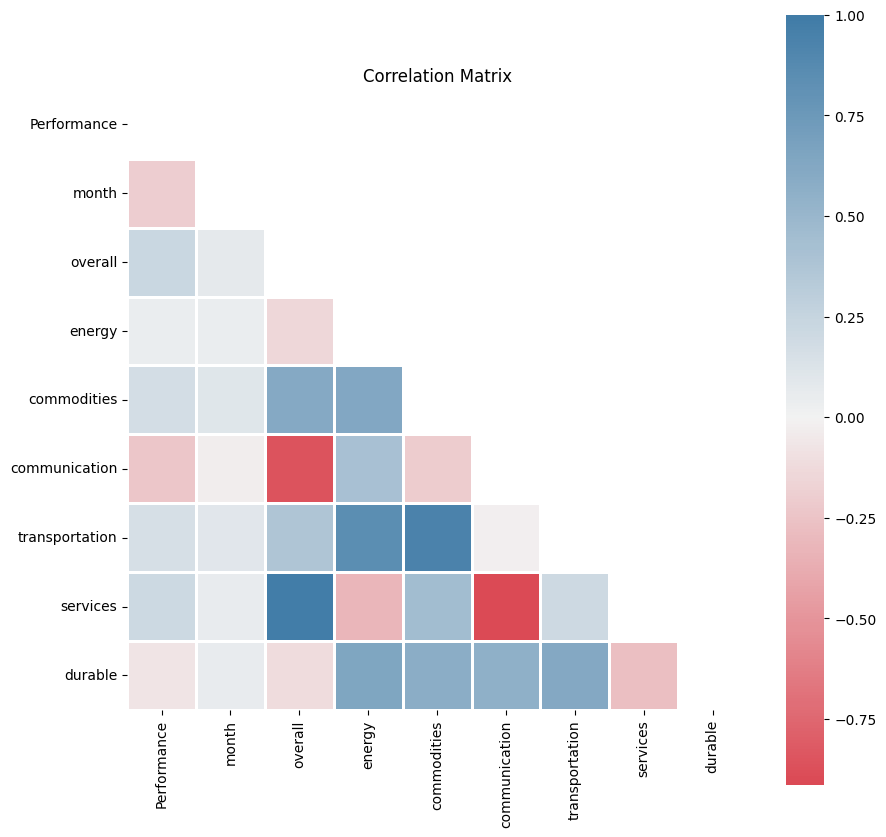

In [8]:
dd.correlation_matrix(original)

### Conditional GAN

In [9]:
discrete_columns = [
    'month'
]

ctgan = CTGAN(epochs=5000)
ctgan.fit(data, discrete_columns)

# Synthetic copy
samples = ctgan.sample(10000)
samples

,month,S&P 500,S&P 500 Industrials (Sector),S&P 500 Performance (%),S&P 500 Industrials (Sector) Performance (%),overall,energy,commodities,communication,transportation,services,durable,dow
0,9,1179.753089,385.555764,-4.496963,-3.900025,233.030336,242.291510,186.795659,84.275112,218.270577,275.294400,113.570764,3
1,12,718.713796,302.027238,-3.774413,-7.000239,219.659384,242.898645,183.400990,83.833836,208.726157,270.392832,110.868354,3
2,2,1086.652653,449.279199,-10.842837,-15.093100,244.111451,171.472651,176.999046,80.334379,198.201620,292.707401,108.413540,3
3,10,2811.721626,690.127493,-9.885297,-13.500142,262.515911,198.909282,184.862927,73.609767,209.675430,326.172071,104.177389,3
4,4,4146.842984,489.538317,8.330693,-0.085989,233.068382,249.041098,186.888025,73.700235,212.973162,324.020103,110.633319,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,6,1000.630446,296.796424,-8.522463,-8.676382,234.129108,203.095356,178.488261,81.488931,193.777127,274.877681,106.077590,3
9996,4,3110.598125,766.947479,11.538393,-4.904591,269.773739,197.395557,184.863185,73.484565,206.706877,330.719420,102.909383,3
9997,11,1361.196696,429.314552,-3.908636,-0.485081,228.826720,212.678913,179.123062,82.093901,203.556549,269.813361,111.282147,3
9998,11,1621.491803,278.655111,-0.989145,-2.876399,226.367254,256.639152,186.897318,82.170201,217.155621,263.683487,111.662768,3


In [10]:
samples['Performance'] = np.where(samples['S&P 500 Industrials (Sector) Performance (%)'] > \
                                  samples['S&P 500 Performance (%)'], 1, 0)

In [11]:
samples = samples[['Performance','month', 'overall','energy', 'commodities',\
                 'communication', 'transportation', 'services','durable']]
samples.head()

,Performance,month,overall,energy,commodities,communication,transportation,services,durable
0,1,9,233.030336,242.291510,186.795659,84.275112,218.270577,275.294400,113.570764
1,0,12,219.659384,242.898645,183.400990,83.833836,208.726157,270.392832,110.868354
2,0,2,244.111451,171.472651,176.999046,80.334379,198.201620,292.707401,108.413540
3,0,10,262.515911,198.909282,184.862927,73.609767,209.675430,326.172071,104.177389
4,0,4,233.068382,249.041098,186.888025,73.700235,212.973162,324.020103,110.633319


In [12]:
dd.data_summary(samples)

,Info
Rows,10000
Columns,9
Size in Memory,703.2 KB


,Data Type,Nulls,Zeros,Min,Median,Max,Mean,Standard Deviation,Unique,Top Frequency
Performance,int64,0,0,0,0,1,0.48,0.50,2,5169
month,int64,0,0,1,7,12,6.52,3.45,12,870
overall,float64,0,0,205.38,237.62,288.20,240.35,15.84,10000,1
energy,float64,0,0,166.82,216.44,265.015,220.47,20.61,10000,1
commodities,float64,0,0,169.73,184.71,216.12,184.46,6.27,10000,1
communication,float64,0,0,71.85,81.21,87.88,79.35,4.26,9999,2
transportation,float64,0,0,183.19,210.40,271.40,209.086,12.40,10000,1
services,float64,0,0,234.48,288.10,371.53,295.77,28.32,10000,1
durable,float64,0,0,101.34,110.41,133.26,109.30,4.44,10000,1


None

data-describe Summary Widget

<AxesSubplot: title={'center': 'Correlation Matrix'}>

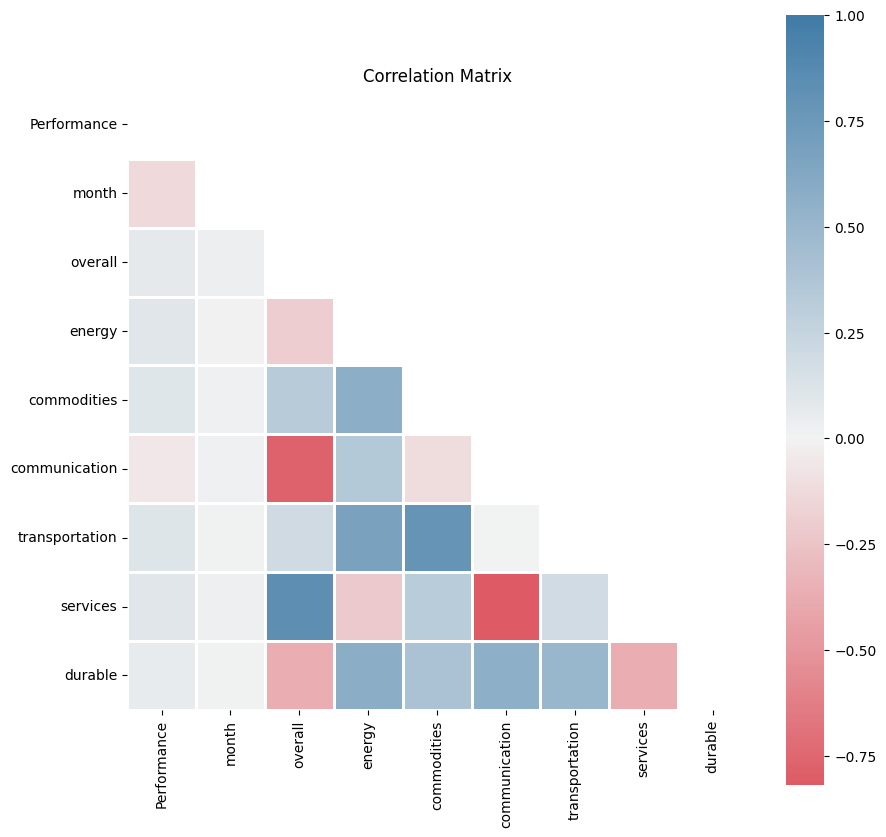

In [13]:
dd.correlation_matrix(samples)

In [14]:
X = samples.drop(['Performance'],axis=1)
y = samples['Performance']

### SMOTE Oversampling

In [15]:
counter = Counter(y)
print(counter)
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)
counter = Counter(y)
print(counter)

Counter({0: 5169, 1: 4831})
Counter({1: 5169, 0: 5169})


### Interaction Terms

In [16]:
poly = PolynomialFeatures(interaction_only=True,include_bias = False)
X_poly = poly.fit_transform(X.drop(['month'],axis=1))
X_poly

array([[  233.03033559,   242.29151005,   186.79565913, ...,
        60088.66752478, 24789.15624147, 31265.39551528],
       [  219.65938406,   242.89864508,   183.40098966, ...,
        56438.0567377 , 23141.12534067, 29978.00814874],
       [  244.11145065,   171.47265065,   176.99904623, ...,
        58015.08111809, 21487.739214  , 31733.44536498],
       ...,
       [  238.57314228,   250.78766006,   186.17299757, ...,
        59533.85689975, 23825.07886872, 30841.82032674],
       [  262.87177929,   212.87120512,   185.13255899, ...,
        69576.86464712, 21654.11899273, 34251.08808437],
       [  227.7058904 ,   195.53032014,   175.0780979 , ...,
        51142.48477766, 21191.43576928, 29619.86170697]])

In [17]:
month = X['month'].to_numpy()
month = np.reshape(month,(-1,1))
X = np.append(X_poly,month,1)
X.shape

(10338, 29)

In [18]:
X_real = original.drop(['Performance'],axis=1)
y_real = original['Performance']
X_real_poly = poly.fit_transform(X_real.drop(['month'],axis=1))
month = X_real['month'].to_numpy()
month = np.reshape(month,(-1,1))
X_real = np.append(X_real_poly,month,1)
X_real.shape

(143, 29)

In [19]:
stscaler = StandardScaler().fit(X)
X = stscaler.transform(X)
X_real = stscaler.transform(X_real)

### Training with CV

In [20]:
random_state = 42
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = random_state)
classifiers = []

classifiers.append(KNeighborsClassifier())
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(BaggingClassifier(random_state=random_state))
classifiers.append(SVC(random_state=random_state))
classifiers.append(GaussianNB())

k_fold = StratifiedKFold(n_splits=10)

Model_Comparison = pd.DataFrame(columns=['Name', 'CV Mean Accuracy', 'CV Mean Precision', 'CV Mean Recall',\
                                         'CV Mean F-1 Score', \
                                         'Accuracy', 'Precision', 'Recall', 'F-1 Score',\
                                        'Accuracy Real', 'Precision Real', 'Recall Real', 'F-1 Score Real'])
row = 0
for clf in classifiers:
    name = clf.__class__.__name__
    Model_Comparison.loc[row, 'Name'] = name
    
    Model_Comparison.loc[row, 'CV Mean Accuracy'] = cross_val_score(clf, X, y, scoring = 'accuracy', \
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean Precision'] = cross_val_score(clf, X, y, scoring = 'precision',\
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean Recall'] = cross_val_score(clf, X, y, scoring = 'recall', \
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean F-1 Score'] = cross_val_score(clf, X, y, scoring = 'f1', \
                                                                 cv = k_fold, n_jobs = 10).mean()

    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    Model_Comparison.loc[row, 'Accuracy'] = accuracy_score(y_test, y_pred)
    Model_Comparison.loc[row, 'Precision'] = precision_score(y_test, y_pred)
    Model_Comparison.loc[row, 'Recall'] = recall_score(y_test, y_pred)
    Model_Comparison.loc[row, 'F-1 Score'] = f1_score(y_test, y_pred)
    
    y_pred = clf.predict(X_real)
    Model_Comparison.loc[row, 'Accuracy Real'] = accuracy_score(y_real, y_pred)
    Model_Comparison.loc[row, 'Precision Real'] = precision_score(y_real, y_pred)
    Model_Comparison.loc[row, 'Recall Real'] = recall_score(y_real, y_pred)
    Model_Comparison.loc[row, 'F-1 Score Real'] = f1_score(y_real, y_pred)
    
    row += 1
Model_Comparison

,Name,CV Mean Accuracy,CV Mean Precision,CV Mean Recall,CV Mean F-1 Score,Accuracy,Precision,Recall,F-1 Score,Accuracy Real,Precision Real,Recall Real,F-1 Score Real
0,KNeighborsClassifier,0.602537,0.599375,0.616195,0.607345,0.594584,0.597026,0.613445,0.605124,0.573427,0.621622,0.582278,0.601307
1,DecisionTreeClassifier,0.584836,0.583948,0.588337,0.585758,0.582592,0.588462,0.584416,0.586432,0.552448,0.592593,0.607595,0.6
2,RandomForestClassifier,0.643649,0.645289,0.637287,0.640644,0.632108,0.63876,0.629488,0.63409,0.594406,0.647887,0.582278,0.613333
3,AdaBoostClassifier,0.641031,0.635617,0.661244,0.648003,0.634043,0.635752,0.649351,0.642479,0.601399,0.648649,0.607595,0.627451
4,GradientBoostingClassifier,0.656799,0.646756,0.691237,0.668178,0.643714,0.644776,0.660046,0.652322,0.566434,0.616438,0.56962,0.592105
5,ExtraTreesClassifier,0.639105,0.639794,0.634394,0.636102,0.625145,0.632812,0.618793,0.625724,0.531469,0.611111,0.417722,0.496241
6,BaggingClassifier,0.624496,0.638524,0.572089,0.603008,0.62089,0.642424,0.566845,0.602273,0.552448,0.61194,0.518987,0.561644
7,SVC,0.618882,0.631993,0.570329,0.599302,0.604642,0.627104,0.540871,0.580804,0.601399,0.683333,0.518987,0.589928
8,GaussianNB,0.565002,0.630699,0.315146,0.419972,0.552805,0.625616,0.291062,0.397289,0.524476,0.72,0.227848,0.346154


## Using data after 2000

In [22]:
data = pd.read_csv('../data/S&P 500 Industrials 50-Day.csv')
data.rename(columns={'Unnamed: 0':'date'}, inplace=True)
data = data.sort_values(by=['date'])
data = data.dropna()
data['date'] = pd.to_datetime(data['date'])
data['month'] = data['date'].dt.month
data['year'] = data['date'].dt.year
data['dow'] = data['date'].dt.dayofweek
data = data[data['dow']==3].groupby(['year','month']).nth[1].reset_index()
data = data[data['year'] >= 2000]
data

,year,month,date,S&P 500,S&P 500 Industrials (Sector),S&P 500 Performance (%),S&P 500 Industrials (Sector) Performance (%),S&P 500 Industrials (Sector) Outperform/Underperform,overall,energy,commodities,communication,transportation,services,durable,dow
25,2000,1,2000-01-13,1449.68,271.299988,-4.867901,0.277213,OUTPERFORM,170.000,118.800,147.600,94.700,150.000,192.500,125.100,3
26,2000,2,2000-02-10,1416.83,242.419998,-0.911278,-11.308671,UNDERPERFORM,171.000,124.300,149.100,94.200,153.600,193.100,125.500,3
27,2000,3,2000-03-09,1401.69,237.440002,-0.373858,-12.160111,UNDERPERFORM,170.900,120.900,148.500,93.800,152.100,193.500,125.400,3
28,2000,4,2000-04-13,1440.51,265.179993,-1.016965,2.631778,OUTPERFORM,171.200,120.000,148.500,93.700,152.000,194.000,125.800,3
29,2000,5,2000-05-11,1407.81,269.410004,-3.857159,-2.697920,OUTPERFORM,172.200,126.800,149.600,92.600,155.000,194.900,125.500,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,2021,7,2021-07-08,4320.82,861.239990,-2.530346,1.777355,OUTPERFORM,273.092,242.958,201.975,76.056,236.783,342.831,120.078,3
284,2021,8,2021-08-12,4460.83,889.830017,-1.849766,0.460629,OUTPERFORM,274.214,245.847,203.215,76.337,237.107,343.808,120.714,3
285,2021,9,2021-09-09,4493.28,863.659973,-4.490556,-3.717911,OUTPERFORM,276.590,255.010,206.035,76.407,241.826,345.648,122.650,3
286,2021,10,2021-10-14,4438.26,861.609985,-7.366228,-3.029728,OUTPERFORM,278.524,261.257,208.467,76.317,246.749,346.911,124.413,3


In [23]:
original = data[['S&P 500 Industrials (Sector) Outperform/Underperform','month','overall','energy', 'commodities',\
                 'communication', 'transportation', 'services','durable']]
data.drop(columns=['date','S&P 500 Industrials (Sector) Outperform/Underperform','year'], inplace=True)
original['Performance'] = np.where(original['S&P 500 Industrials (Sector) Outperform/Underperform'] == 'OUTPERFORM',1,0)
original = original[['Performance','month','overall','energy', 'commodities',\
                 'communication', 'transportation', 'services','durable']]
discrete_columns = [
    'month'
]

ctgan = CTGAN(epochs=5000)
ctgan.fit(data, discrete_columns)

# Synthetic copy
samples = ctgan.sample(10000)
samples

,month,S&P 500,S&P 500 Industrials (Sector),S&P 500 Performance (%),S&P 500 Industrials (Sector) Performance (%),overall,energy,commodities,communication,transportation,services,durable,dow
0,8,2110.958681,258.379140,-4.782106,1.232604,225.467681,197.602846,165.738902,80.645182,192.801639,269.722497,115.056350,3
1,6,2648.537954,254.667456,-1.571094,-3.476868,247.763256,238.548268,184.826395,83.898296,213.400813,316.858513,110.895774,3
2,6,987.592992,207.527225,-6.636106,0.598006,172.896164,122.011685,145.520616,95.398648,160.836906,199.133137,124.321658,3
3,10,1322.209645,333.066169,-10.047342,-12.830396,202.294565,248.006224,186.171588,83.617977,210.958597,269.537247,112.973796,3
4,9,1081.708215,241.023739,-2.614365,-6.230558,191.767849,124.637088,156.518851,94.525203,156.733190,221.317215,111.296391,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,5,1144.188943,230.048189,-3.325952,0.384760,183.984382,120.510958,151.937036,86.785146,156.400230,230.466797,111.152472,3
9996,5,2307.103112,705.643511,-10.149358,-14.031789,263.293592,203.099909,179.291959,75.253691,203.725615,304.361124,106.142890,3
9997,4,1884.030433,444.176067,-2.656018,-5.778968,230.501623,216.057614,182.684828,79.519017,218.286567,310.350402,109.510146,3
9998,4,988.774096,212.449846,1.990531,-6.054458,204.171655,146.168536,151.279519,85.035344,156.109243,261.843257,113.724164,3


In [24]:
samples['Performance'] = np.where(samples['S&P 500 Industrials (Sector) Performance (%)'] > \
                                  samples['S&P 500 Performance (%)'], 1, 0)
samples = samples[['Performance','month', 'overall','energy', 'commodities',\
                 'communication', 'transportation', 'services','durable']]
X = samples.drop(['Performance'],axis=1)
y = samples['Performance']
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)
poly = PolynomialFeatures(interaction_only=True,include_bias = False)
X_poly = poly.fit_transform(X.drop(['month'],axis=1))
month = X['month'].to_numpy()
month = np.reshape(month,(-1,1))
X = np.append(X_poly,month,1)
X_real = original.drop(['Performance'],axis=1)
y_real = original['Performance']
X_real_poly = poly.fit_transform(X_real.drop(['month'],axis=1))
month = X_real['month'].to_numpy()
month = np.reshape(month,(-1,1))
X_real = np.append(X_real_poly,month,1)
stscaler = StandardScaler().fit(X)
X = stscaler.transform(X)
X_real = stscaler.transform(X_real)
random_state = 42
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = random_state)
classifiers = []

classifiers.append(KNeighborsClassifier())
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(BaggingClassifier(random_state=random_state))
classifiers.append(SVC(random_state=random_state))
classifiers.append(GaussianNB())

k_fold = StratifiedKFold(n_splits=10)

Model_Comparison = pd.DataFrame(columns=['Name', 'CV Mean Accuracy', 'CV Mean Precision', 'CV Mean Recall',\
                                         'CV Mean F-1 Score', \
                                         'Accuracy', 'Precision', 'Recall', 'F-1 Score',\
                                        'Accuracy Real', 'Precision Real', 'Recall Real', 'F-1 Score Real'])
row = 0
for clf in classifiers:
    name = clf.__class__.__name__
    Model_Comparison.loc[row, 'Name'] = name
    
    Model_Comparison.loc[row, 'CV Mean Accuracy'] = cross_val_score(clf, X, y, scoring = 'accuracy', \
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean Precision'] = cross_val_score(clf, X, y, scoring = 'precision',\
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean Recall'] = cross_val_score(clf, X, y, scoring = 'recall', \
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean F-1 Score'] = cross_val_score(clf, X, y, scoring = 'f1', \
                                                                 cv = k_fold, n_jobs = 10).mean()

    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    Model_Comparison.loc[row, 'Accuracy'] = accuracy_score(y_test, y_pred)
    Model_Comparison.loc[row, 'Precision'] = precision_score(y_test, y_pred)
    Model_Comparison.loc[row, 'Recall'] = recall_score(y_test, y_pred)
    Model_Comparison.loc[row, 'F-1 Score'] = f1_score(y_test, y_pred)
    
    y_pred = clf.predict(X_real)
    Model_Comparison.loc[row, 'Accuracy Real'] = accuracy_score(y_real, y_pred)
    Model_Comparison.loc[row, 'Precision Real'] = precision_score(y_real, y_pred)
    Model_Comparison.loc[row, 'Recall Real'] = recall_score(y_real, y_pred)
    Model_Comparison.loc[row, 'F-1 Score Real'] = f1_score(y_real, y_pred)
    
    row += 1
Model_Comparison

,Name,CV Mean Accuracy,CV Mean Precision,CV Mean Recall,CV Mean F-1 Score,Accuracy,Precision,Recall,F-1 Score,Accuracy Real,Precision Real,Recall Real,F-1 Score Real
0,KNeighborsClassifier,0.702209,0.681678,0.755885,0.716406,0.696506,0.683744,0.724046,0.703318,0.460076,0.465116,0.451128,0.458015
1,DecisionTreeClassifier,0.670668,0.659526,0.700467,0.678093,0.667887,0.661238,0.679839,0.67041,0.479087,0.483871,0.451128,0.466926
2,RandomForestClassifier,0.758207,0.746936,0.777856,0.760214,0.753078,0.744625,0.765573,0.754954,0.429658,0.432,0.406015,0.418605
3,AdaBoostClassifier,0.701367,0.696629,0.713435,0.704681,0.701498,0.69657,0.707301,0.701894,0.467681,0.46789,0.383459,0.421488
4,GradientBoostingClassifier,0.710438,0.701938,0.731743,0.716199,0.714809,0.708936,0.722706,0.715755,0.490494,0.495798,0.443609,0.468254
5,ExtraTreesClassifier,0.770857,0.758892,0.79034,0.77226,0.763062,0.757416,0.769591,0.763455,0.425856,0.428571,0.406015,0.416988
6,BaggingClassifier,0.724257,0.735017,0.697973,0.714228,0.718136,0.733382,0.679839,0.705596,0.513308,0.529412,0.338346,0.412844
7,SVC,0.686306,0.68013,0.703615,0.691494,0.687521,0.67825,0.705961,0.691828,0.422053,0.422764,0.390977,0.40625
8,GaussianNB,0.664422,0.704216,0.567152,0.628088,0.667554,0.705833,0.567314,0.629038,0.441065,0.432692,0.338346,0.379747


## Using all data (Best Model)

In [25]:
data = pd.read_csv('../data/S&P 500 Industrials 50-Day.csv')
data.rename(columns={'Unnamed: 0':'date'}, inplace=True)
data = data.sort_values(by=['date'])
data = data.dropna()
data['date'] = pd.to_datetime(data['date'])
data['month'] = data['date'].dt.month
data['year'] = data['date'].dt.year
data['dow'] = data['date'].dt.dayofweek
data = data[data['dow']==3].groupby(['year','month']).nth[1].reset_index()
data

,year,month,date,S&P 500,S&P 500 Industrials (Sector),S&P 500 Performance (%),S&P 500 Industrials (Sector) Performance (%),S&P 500 Industrials (Sector) Outperform/Underperform,overall,energy,commodities,communication,transportation,services,durable,dow
0,1997,12,1997-12-11,954.94,205.309998,-8.434174,-7.019610,OUTPERFORM,162.000,107.500,142.000,99.600,143.000,182.100,127.800,3
1,1998,1,1998-01-15,950.73,203.119995,-13.064192,-12.887594,OUTPERFORM,162.000,105.100,141.800,99.200,142.400,182.300,127.900,3
2,1998,2,1998-02-12,1024.14,220.029999,-5.743001,-2.095758,OUTPERFORM,162.000,103.300,141.400,99.300,141.500,182.800,127.700,3
3,1998,3,1998-03-12,1069.92,227.740005,-3.651607,-0.021945,OUTPERFORM,162.200,102.400,141.300,99.300,140.900,183.300,127.800,3
4,1998,4,1998-04-09,1110.67,235.630005,0.676209,7.070476,OUTPERFORM,162.600,103.200,141.700,99.400,141.200,183.700,127.500,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,2021,7,2021-07-08,4320.82,861.239990,-2.530346,1.777355,OUTPERFORM,273.092,242.958,201.975,76.056,236.783,342.831,120.078,3
284,2021,8,2021-08-12,4460.83,889.830017,-1.849766,0.460629,OUTPERFORM,274.214,245.847,203.215,76.337,237.107,343.808,120.714,3
285,2021,9,2021-09-09,4493.28,863.659973,-4.490556,-3.717911,OUTPERFORM,276.590,255.010,206.035,76.407,241.826,345.648,122.650,3
286,2021,10,2021-10-14,4438.26,861.609985,-7.366228,-3.029728,OUTPERFORM,278.524,261.257,208.467,76.317,246.749,346.911,124.413,3


In [26]:
original = data[['S&P 500 Industrials (Sector) Outperform/Underperform','month','overall','energy', 'commodities',\
                 'communication', 'transportation', 'services','durable']]
data.drop(columns=['date','S&P 500 Industrials (Sector) Outperform/Underperform','year'], inplace=True)
original['Performance'] = np.where(original['S&P 500 Industrials (Sector) Outperform/Underperform'] == 'OUTPERFORM',1,0)
original = original[['Performance','month','overall','energy', 'commodities',\
                 'communication', 'transportation', 'services','durable']]
discrete_columns = [
    'month'
]

ctgan = CTGAN(epochs=5000)
ctgan.fit(data, discrete_columns)

# Synthetic copy
samples = ctgan.sample(10000)
samples

,month,S&P 500,S&P 500 Industrials (Sector),S&P 500 Performance (%),S&P 500 Industrials (Sector) Performance (%),overall,energy,commodities,communication,transportation,services,durable,dow
0,10,1011.104014,205.354031,-2.772244,-2.583718,168.009183,129.148710,150.288819,90.578202,141.419294,177.930487,124.823472,3
1,12,1133.215694,212.576925,-0.940762,0.001233,167.317612,120.260383,146.082543,91.652275,152.429121,180.790991,122.833314,3
2,3,1293.760110,249.122347,-5.022480,-9.602855,218.925359,205.540838,167.716209,83.642563,193.876914,262.771873,110.812936,3
3,10,1229.605127,301.790794,-3.881062,-8.393536,229.439796,256.305566,168.278021,82.824002,207.573201,244.146172,114.101518,3
4,8,1236.655451,260.967195,4.777293,-4.472230,212.839662,193.863869,145.126762,84.440652,173.091554,190.166461,113.758762,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,8,1163.531830,250.257713,-4.665096,-8.481126,233.687621,246.073684,171.044050,84.187497,210.906049,261.685929,109.546693,3
9996,11,1172.309362,462.511277,-7.496295,-6.312027,221.309013,245.020466,174.599826,83.702042,198.163681,257.597775,113.121700,3
9997,6,2736.275822,592.530775,-1.070246,-1.087848,225.541883,212.468664,167.937874,82.549929,194.555460,271.090022,105.190480,3
9998,6,1133.237314,200.189585,-1.871972,0.309166,174.373724,114.061815,149.639463,92.246572,141.420285,192.119590,122.801269,3


In [27]:
samples['Performance'] = np.where(samples['S&P 500 Industrials (Sector) Performance (%)'] > \
                                  samples['S&P 500 Performance (%)'], 1, 0)
samples = samples[['Performance','month', 'overall','energy', 'commodities',\
                 'communication', 'transportation', 'services','durable']]
X = samples.drop(['Performance'],axis=1)
y = samples['Performance']
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)
poly = PolynomialFeatures(interaction_only=True,include_bias = False)
X_poly = poly.fit_transform(X.drop(['month'],axis=1))
month = X['month'].to_numpy()
month = np.reshape(month,(-1,1))
X = np.append(X_poly,month,1)
X_real = original.drop(['Performance'],axis=1)
y_real = original['Performance']
X_real_poly = poly.fit_transform(X_real.drop(['month'],axis=1))
month = X_real['month'].to_numpy()
month = np.reshape(month,(-1,1))
X_real = np.append(X_real_poly,month,1)
stscaler = StandardScaler().fit(X)
X = stscaler.transform(X)
X_real = stscaler.transform(X_real)
random_state = 42
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = random_state)
classifiers = []

classifiers.append(KNeighborsClassifier())
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(BaggingClassifier(random_state=random_state))
classifiers.append(SVC(random_state=random_state))
classifiers.append(GaussianNB())

k_fold = StratifiedKFold(n_splits=10)

Model_Comparison = pd.DataFrame(columns=['Name', 'CV Mean Accuracy', 'CV Mean Precision', 'CV Mean Recall',\
                                         'CV Mean F-1 Score', \
                                         'Accuracy', 'Precision', 'Recall', 'F-1 Score',\
                                        'Accuracy Real', 'Precision Real', 'Recall Real', 'F-1 Score Real'])
row = 0
for clf in classifiers:
    name = clf.__class__.__name__
    Model_Comparison.loc[row, 'Name'] = name
    
    Model_Comparison.loc[row, 'CV Mean Accuracy'] = cross_val_score(clf, X, y, scoring = 'accuracy', \
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean Precision'] = cross_val_score(clf, X, y, scoring = 'precision',\
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean Recall'] = cross_val_score(clf, X, y, scoring = 'recall', \
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean F-1 Score'] = cross_val_score(clf, X, y, scoring = 'f1', \
                                                                 cv = k_fold, n_jobs = 10).mean()

    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    Model_Comparison.loc[row, 'Accuracy'] = accuracy_score(y_test, y_pred)
    Model_Comparison.loc[row, 'Precision'] = precision_score(y_test, y_pred)
    Model_Comparison.loc[row, 'Recall'] = recall_score(y_test, y_pred)
    Model_Comparison.loc[row, 'F-1 Score'] = f1_score(y_test, y_pred)
    
    y_pred = clf.predict(X_real)
    Model_Comparison.loc[row, 'Accuracy Real'] = accuracy_score(y_real, y_pred)
    Model_Comparison.loc[row, 'Precision Real'] = precision_score(y_real, y_pred)
    Model_Comparison.loc[row, 'Recall Real'] = recall_score(y_real, y_pred)
    Model_Comparison.loc[row, 'F-1 Score Real'] = f1_score(y_real, y_pred)
    
    row += 1
Model_Comparison

,Name,CV Mean Accuracy,CV Mean Precision,CV Mean Recall,CV Mean F-1 Score,Accuracy,Precision,Recall,F-1 Score,Accuracy Real,Precision Real,Recall Real,F-1 Score Real
0,KNeighborsClassifier,0.685019,0.645363,0.817131,0.720684,0.659059,0.622431,0.792378,0.697197,0.520833,0.554745,0.496732,0.524138
1,DecisionTreeClassifier,0.666206,0.652217,0.709048,0.678738,0.647506,0.632376,0.688851,0.659406,0.475694,0.509091,0.366013,0.425856
2,RandomForestClassifier,0.791761,0.771472,0.824753,0.795107,0.755424,0.735201,0.79124,0.762192,0.541667,0.606061,0.392157,0.47619
3,AdaBoostClassifier,0.617379,0.617167,0.617177,0.61691,0.612849,0.603337,0.637656,0.620022,0.541667,0.588235,0.457516,0.514706
4,GradientBoostingClassifier,0.637741,0.631528,0.659734,0.644921,0.639053,0.627064,0.669511,0.647593,0.53125,0.572581,0.464052,0.512635
5,ExtraTreesClassifier,0.833396,0.816665,0.858006,0.834552,0.792336,0.778809,0.811149,0.79465,0.524306,0.614286,0.281046,0.38565
6,BaggingClassifier,0.734055,0.737579,0.723719,0.728924,0.715976,0.72509,0.687144,0.705607,0.517361,0.576087,0.346405,0.432653
7,SVC,0.597444,0.587807,0.648883,0.616628,0.59876,0.583417,0.664391,0.621277,0.527778,0.556291,0.54902,0.552632
8,GaussianNB,0.551712,0.564714,0.453578,0.50282,0.544097,0.547945,0.455063,0.497203,0.565972,0.642857,0.411765,0.501992


### Voting Classifier

In [28]:
et_clf = ExtraTreesClassifier(random_state=random_state)
bag_clf = BaggingClassifier(random_state=random_state)
rf_clf = RandomForestClassifier(random_state=random_state)
classifiers = [('RF', rf_clf), \
               ('ET', et_clf),\
              ('Bagging', bag_clf)]

vc = VotingClassifier(estimators = classifiers, voting = 'soft')     
vc.fit(x_train, y_train)
y_pred = vc.predict(x_test)
vc_res = pd.DataFrame(columns=['Accuracy', 'Precision', 'Recall', 'F-1 Score'])
vc_res.loc[0, 'Accuracy'] = accuracy_score(y_test, y_pred)
vc_res.loc[0, 'Precision'] = precision_score(y_test, y_pred)
vc_res.loc[0, 'Recall'] = recall_score(y_test, y_pred)
vc_res.loc[0, 'F-1 Score'] = f1_score(y_test, y_pred)
vc_res

,Accuracy,Precision,Recall,F-1 Score
0,0.767258,0.746561,0.802617,0.773575
